<a href="https://colab.research.google.com/github/KajalMishra-29/ML-LungCancerClassifier/blob/main/cnn_lung_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [29]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

IMAGE &nbsp;PREPROCESSING

In [30]:
directory = '/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset'
categories = ['Benign_cases', 'Malignant_cases', 'Normal_cases']

def preprocess_image(img):
    img = cv2.resize(img, (224, 224)) # resize to fixed shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale (suitable for CNN)
    img = img / 255.0 # normalize pixel values to [0, 1]

    # expand dimension to add a channel axis (since grayscale = 1 channel)
    img = np.expand_dims(img, axis=-1) # shape becomes (244, 244, 1)

    return img


data = []
for i in categories:
  path = os.path.join(directory, i)
  class_num = categories.index(i)
  print(path)
  for file in os.listdir(path):
    file_path = os.path.join(path, file)
    img = cv2.imread(file_path)
    # preprocess image
    img = preprocess_image(img)
    data.append([img, class_num]);

random.shuffle(data)

X, y = [], []
for feature, label in data:
  X.append(feature)
  y.append(label)

print('X length : ', len(X));
print('y counts : ', Counter(y))


/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset/Benign_cases
/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset/Malignant_cases
/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset/Normal_cases
X length :  1097
y counts :  Counter({1: 561, 2: 416, 0: 120})


SPLITTING &nbsp;DATA
* Train: 70%
* Validation: 15%
* Test: 15%

In [31]:
X = np.array(X)
y = np.array(y)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10, stratify=y_temp)

print("Training set size: ", X_train.shape, y_train.shape)
print("Validation set size: ", X_valid.shape, y_valid.shape)
print("Testing set size: ", X_test.shape, y_test.shape)


Training set size:  (383, 224, 224, 1) (383,)
Validation set size:  (384, 224, 224, 1) (384,)
Testing set size:  (330, 224, 224, 1) (330,)


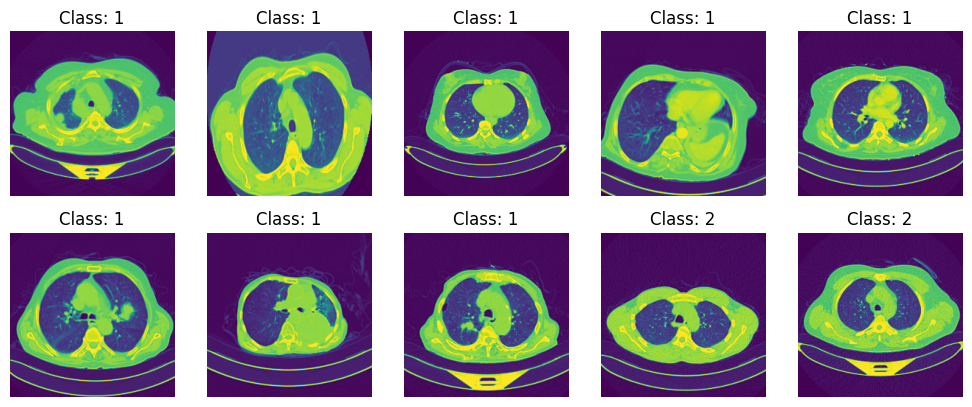

In [32]:
plt.figure(figsize=(10,10))
for i in range(10,20):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
  plt.title(f"Class: {y_train[i]}")
plt.tight_layout()
plt.show()

CLASS WEIGHTS - to handle class imbalance during training

In [33]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}
new_weights

{0: 3.0396825396825395, 1: 0.6513605442176871, 2: 0.8804597701149425}

In [34]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(16))
model.add(Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 222, 222, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │     2,986,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,023,619 (11.53 MB)

 Trainable params: 3,023,619 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# callbacks for deep learning model

# early stopping - training stops if monitored metric (e.g., val_loss) doesnt improve , helps prevent overfitting and saves training time
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# ReduceLROnPlateau - reduce the learning rate when the monitored metric (e.g., val_loss) has stopped improving, which can help the model converge more smoothly
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [36]:
history = model.fit(
    X_train, y_train,batch_size=8,
    epochs=30,
    validation_data=(X_valid, y_valid),
    class_weight=new_weights,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4138 - loss: 3.2978 - val_accuracy: 0.6432 - val_loss: 0.8292 - learning_rate: 0.0010
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7692 - loss: 0.6584 - val_accuracy: 0.9010 - val_loss: 0.3437 - learning_rate: 0.0010
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9301 - loss: 0.2276 - val_accuracy: 0.9375 - val_loss: 0.1600 - learning_rate: 0.0010
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9866 - loss: 0.0744 - val_accuracy: 0.9714 - val_loss: 0.1075 - learning_rate: 0.0010
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9999 - loss: 0.0184 - val_accuracy: 0.9531 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9768 - loss: 0.0744 - val_accuracy: 0.9531 - val_loss: 0.1077 - learning_rate: 0.0010
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9930 - loss: 0.0457 - val_acc

#Report

In [37]:
y_pred = model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Accuracy: 0.9667


Plot Accuracy & Loss Curves

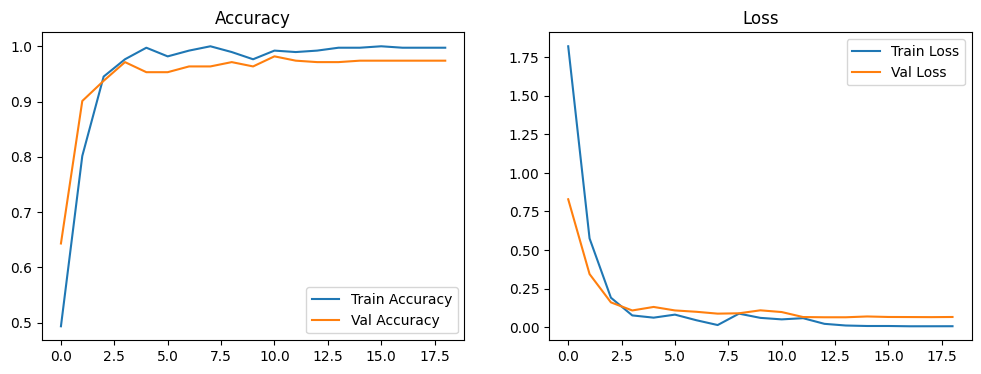

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


Classification Metrics (Precision, Recall, F1-score)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

      Benign       0.89      0.86      0.87        36
   Malignant       0.99      0.97      0.98       169
      Normal       0.95      0.99      0.97       125

    accuracy                           0.97       330
   macro avg       0.94      0.94      0.94       330
weighted avg       0.97      0.97      0.97       330



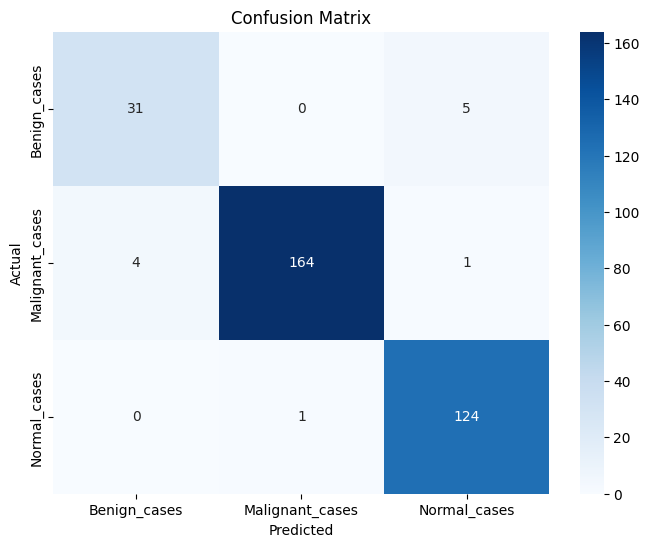

In [41]:
y_pred = model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool, target_names=["Benign", "Malignant", "Normal"]))

# Plot the confusion matrix as a heatmap
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


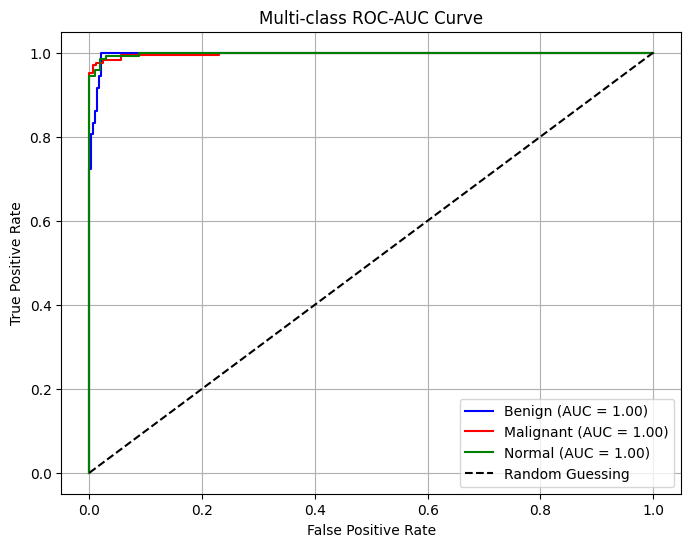

In [42]:
# Binarize the labels for ROC-AUC (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
labels = ['Benign', 'Malignant', 'Normal']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC-AUC Curve')
plt.legend()
plt.grid()
plt.show()
